In [1]:
import wandb
import wandb.apis
import pandas as pd
from typing import *
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

api = wandb.Api()

In [9]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    if "count" in run.summary:
        task = run.config["task"]["name"]
        assert run.summary["count"] == dict(squad=1000, cnn_dailymail=500)[task]
        assert run.config["model"] == "EleutherAI/pythia-1.4b"
        mc = run.summary["model_config"] if "model_config" in run.summary else {}
        d = run.config["sparsity"]
        if "importance" in d:
            d.update({f"importance_{k}": v for k, v in d.pop("importance").items()})
        return dict(
            task=task,
            **d,
            n_heads=mc.get("num_attention_heads", 16),
            head_size=mc.get("hidden_size", 2048)//mc.get("num_attention_heads", 16),
            prefill_length=run.summary["prefill_length"],
            match=run.summary.get("match"),
            rougeL=run.summary.get("rougeL"),
        )

def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run)
        for run in api.runs(
            "research/sparse-attention", {"$or": [
                {"config.name": experiment_name},
                *({"display_name": n} for n in single_runs)
            ]}
        )
    )))

def memory_transfers_attention_only(s: pd.Series) -> int:
    kv_elements = 0
    index_elements = 0
    if s["name"] == "dense":
        # write current + read all KVs
        kv_elements = (2 + 2 * s["prefill_length"]) * s["head_size"] * s["n_heads"]

    elif s["name"] in {"eviction", "ann_low_rank"}:
        # TODO: not counting eviction scores
        kv_elements = (2 + 2 * s["k"]) * s["head_size"] * s["n_heads"]
        if s["name"] == "ann_low_rank":
            index_elements = (2 + 2 * s["prefill_length"]) * s["rank"] * s["n_heads"]

    else:
        assert False, s["name"]

    return kv_elements + index_elements

df = (
    pd.concat([load_sweep("RMOE-53-low-rank-v4", "upbeat-star-110", "comic-lake-172"),
               load_sweep("RMOE-52-eviction-v3")])
    .pipe(lambda d: d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1)))
    .pipe(lambda d: d.assign(score=d.match.where(~d.match.isna(), d.rougeL)))
    # .pipe(lambda d: d[(d["name"] != "eviction") | ((d["importance_metric"] == "weight") & (d["importance_reduction"] == "sum"))])
    .pipe(lambda d: d[(d["name"] != "eviction") | ((d["importance_metric"] == "threshold") & (d["importance_reduction"] == "decaymax")
                                                   & (d["importance_metric_threshold"] == 1))])
)
df.groupby("task").apply(lambda d: d.sort_values("score", ascending=False).head())[["name", "k", "rank", "init", "transfers", "score"]]

name       k  rank         init   transfers   
task                                                                    
cnn_dailymail 20  ann_low_rank   256.0  64.0  orthonormal  3520942.08  \
              16  ann_low_rank   512.0  64.0  orthonormal  4569518.08   
              17  ann_low_rank   512.0  32.0  orthonormal  3335383.04   
              64         dense     NaN   NaN          NaN  4936540.16   
              18  ann_low_rank   512.0  16.0  orthonormal  2718315.52   
squad         65         dense     NaN   NaN          NaN  5786644.48   
              48  ann_low_rank   512.0  64.0  orthonormal  4992522.24   
              52  ann_low_rank   256.0  64.0  orthonormal  3943946.24   
              49  ann_low_rank   512.0  32.0  orthonormal  3546885.12   
              3       eviction  1024.0   NaN          NaN  4198400.00   

                     score  
task                        
cnn_dailymail 20  0.184449  
              16  0.181532  
              17  0.180980  
              64  0.179742  
              18  0.179735  
squad         65  0.428000  
              48  0.423000  
              52  0.418000  
              49  0.417000  
              3   0.416000

## Orthonormal init is better, especially for large-rank, low-k

In [3]:
(df.groupby(["task", "k", "rank"]).apply(lambda d: d[d.init=="orthonormal"].score.item()/d[d.init=="normal"].score.item() if len(d) == 2 else None).to_frame("orthonormal_ratio")
 .reset_index().pivot(index=["task", "k"], columns="rank", values="orthonormal_ratio").style.pipe(lambda s: s.background_gradient(cmap="coolwarm_r", vmin=0, vmax=2)))

## Rank can be traded off against sparse-k

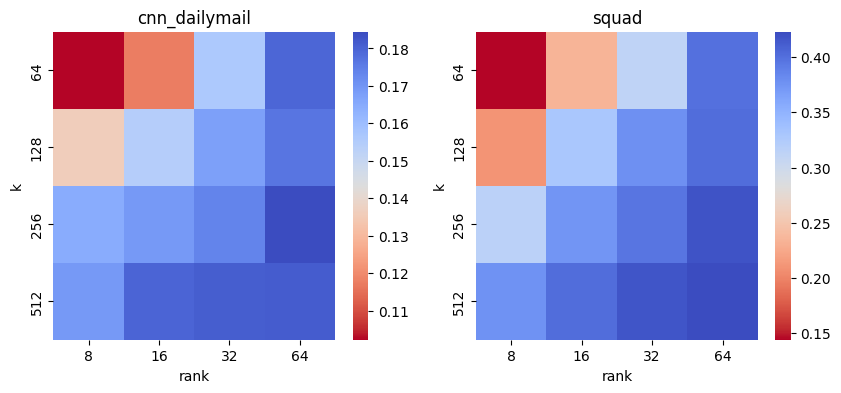

In [4]:
_, axs = plt.subplots(1, 2, figsize=(10, 4))
for ax, (task, g) in zip(axs, df.groupby("task")):
    sns.heatmap(g.pipe(lambda d: d[d.init=="orthonormal"])
                .pipe(lambda d: d.assign(k=d.k.astype("long"), rank=d["rank"].astype("long")))
                .pivot(index="k", columns="rank", values="score"),
                cmap="coolwarm_r", ax=ax)
    ax.set_title(task)

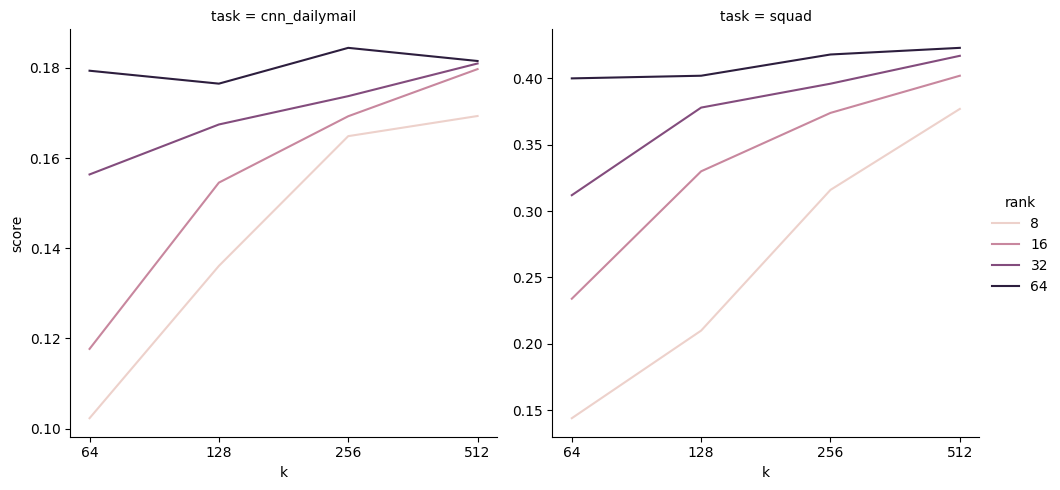

In [5]:
g = sns.relplot(data=df.pipe(lambda d: d[d.init=="orthonormal"]).pipe(lambda d: d.assign(rank=d["rank"].astype("long"))), y="score",
            x="k", hue="rank",
            col="task", hue_norm=matplotlib.colors.LogNorm(), kind="line", facet_kws=dict(sharey=False))
for ax in g.axes.flatten():
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

## Low-rank ANN has a sweet spot vs eviction

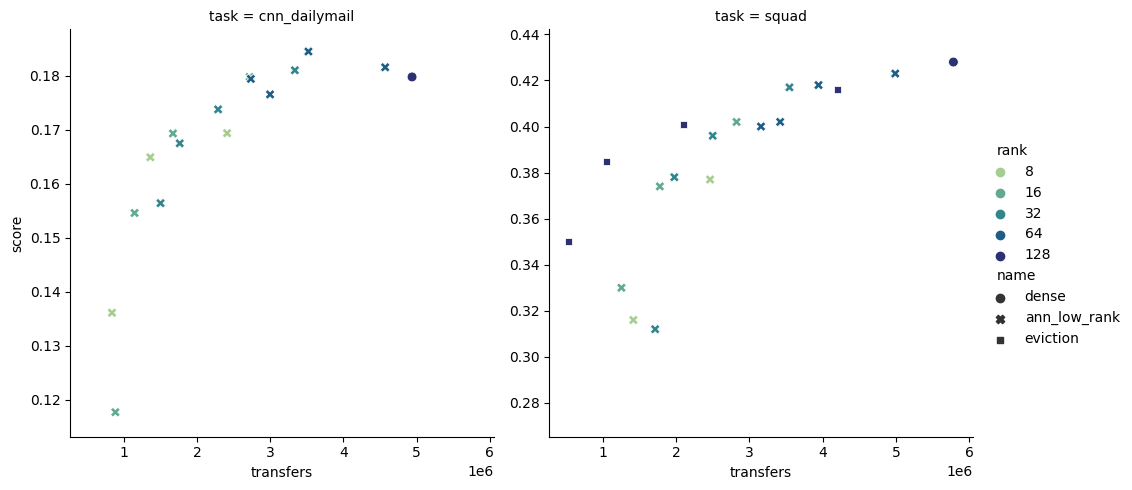

In [6]:
g = sns.relplot(data=df.pipe(lambda d: d.assign(rank=d["rank"].fillna(d["head_size"]).astype("long")))
                    .pipe(lambda d: d[d.init.isna() | (d.init == "orthonormal")]),
                y="score", x="transfers", col="task", style="name", style_order=["dense", "ann_low_rank", "eviction"],
                hue="rank", hue_norm=matplotlib.colors.LogNorm(), palette="crest",
                facet_kws=dict(sharey=False), s=50)
for ax in g.axes.flatten():
    ymax = ax.get_ylim()[1]
    ax.set_ylim((ymax*.6, ymax))

## Best results with transfers under a threshold (4e6)

In [7]:
(df.pipe(lambda d: d[d.task == "squad"])
 .pipe(lambda d: d[d.init.isna() | (d.init == "orthonormal")])
 .pipe(lambda d: d[d.transfers < 4e6])
 .sort_values("score", ascending=False)
 [["name", "k", "rank", "match"]])

,name,k,rank,match
52,ann_low_rank,256.0,64.0,0.418
49,ann_low_rank,512.0,32.0,0.417
56,ann_low_rank,128.0,64.0,0.402
50,ann_low_rank,512.0,16.0,0.402
17,eviction,512.0,NaN,0.401
60,ann_low_rank,64.0,64.0,0.400
53,ann_low_rank,256.0,32.0,0.396
30,eviction,256.0,NaN,0.385
57,ann_low_rank,128.0,32.0,0.378
51,ann_low_rank,512.0,8.0,0.377
